# Clustering para clasificar años según características de exportación

El siguiente notebook es un trabajo inicial que permite ver la utilidad de procesos de clustering para poder clasificar años según características de exportación. En este caso se utilizaron las características de "% de Exportaciones de los 5 Principales Destinos" y "% de Exportación de los 5 Principales Productos". 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
from scipy.cluster.hierarchy import dendrogram, linkage

In [3]:
data = pd.read_excel('grafico 3.xlsx')
data = data[['Año','5xDestino','5xNCM','expo']]
data.head()

,Año,5xDestino,5xNCM,expo
0,2000,0.559,0.317,26341.028985
1,2001,0.538,0.320,26542.726339
2,2002,0.502,0.320,25650.598711
3,2003,0.509,0.359,29938.752615
4,2004,0.495,0.327,34575.733702


In [27]:
scaler = StandardScaler()
features_2 = data.iloc[:,1:3].to_numpy()
scaled_features_2 = scaler.fit_transform(features_2)

## Definimos parámetro K 

In [12]:
kmeans_kwargs = {
  "init": "random",
  "n_init": 10,
  "max_iter": 300,
  "random_state": 42,
  }
   
# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
  kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
  kmeans.fit(scaled_features_2)
  sse.append(kmeans.inertia_)

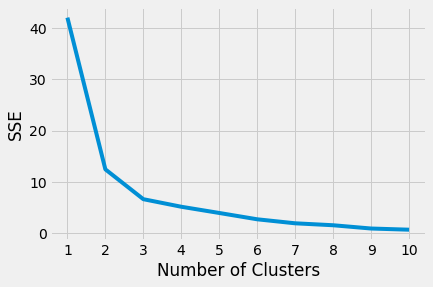

In [13]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [23]:
kl = KneeLocator(
  range(1, 11), sse, curve="convex", direction="decreasing"
  )

In [24]:
kl.elbow

3

Hemos verificados que con k = 3 obtenemos una buena division de clusters. Vamos a verificarlo a través de un dendograma

## Dendograma

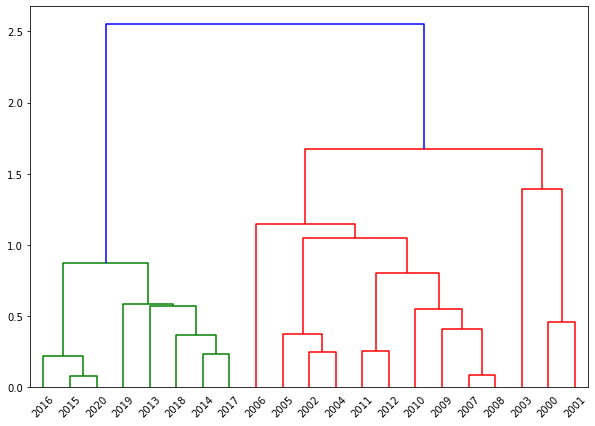

In [29]:
#X = data.iloc[:,1:3].to_numpy()
linked = linkage(scaled_features_2, 'average')

labelList = data['Año'].to_numpy()

plt.figure(figsize=(10, 7))
dendrogram(linked,
            orientation='top',
            labels=labelList,
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()

## Obtenemos labels

In [32]:
kmeans2 = KMeans(
     init="random",
     n_clusters=3,
     n_init=10,
     max_iter=300,
     random_state=42)

In [33]:
kmeans2.fit(scaled_features_2)

KMeans(algorithm='auto', copy_x=True, init='random', max_iter=300, n_clusters=3,
       n_init=10, n_jobs=None, precompute_distances='auto', random_state=42,
       tol=0.0001, verbose=0)

In [9]:
kmeans2.cluster_centers_

array([[-0.00260916, -0.81739529],
       [ 1.31587278, -0.5755249 ],
       [-0.98462156,  1.14686456]])

In [11]:
kmeans2.labels_

array([1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2])

In [15]:
kmeans2.labels_

array([1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2])

In [16]:
 #Agregamos labels de clusters predecidos a cada fila. 
data['cluster_label_2'] = kmeans2.labels_
data.head()

,Año,5xDestino,5xNCM,expo,cluster_label_2
0,2000,0.559,0.317,26341.028985,1
1,2001,0.538,0.320,26542.726339,1
2,2002,0.502,0.320,25650.598711,1
3,2003,0.509,0.359,29938.752615,1
4,2004,0.495,0.327,34575.733702,1


In [34]:
clusters = kmeans2.fit_predict(scaled_features_2)

In [35]:
# obtaining the centers of the clusters
centroids = kmeans2.cluster_centers_
# points array will be used to reach the index easy
points = np.empty((0,len(scaled_features_2[0])), float)
# distances will be used to calculate outliers
distances = np.empty((0,len(scaled_features_2[0])), float)
# getting points and distances
for i, center_elem in enumerate(centroids):
    # cdist is used to calculate the distance between center and other points
    distances = np.append(distances, cdist([center_elem],scaled_features_2[clusters == i], 'euclidean')) 
    points = np.append(points, scaled_features_2[clusters == i], axis=0)

Notamos que a medida que pasan los años la tendencia se va confirmando porque las distancias se acortan. 

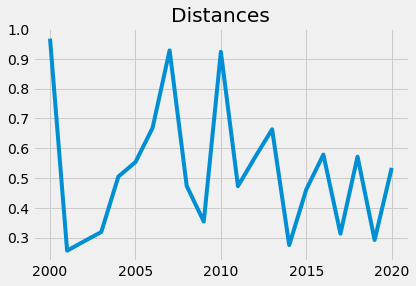

In [26]:
plt.plot(data['Año'],distances)
plt.title("Distances")
plt.show()

In [39]:
#percentile = 0.9
# getting outliers whose distances are greater than some percentile
#outliers = points[np.where(distances > np.percentile(distances, percentile))]

#Tomamos outliers como x > Q3*1.5
outliers = points[np.where(distances > np.quantile(distances, 0.75)*1.5)]


Observamos los centroides, los puntos de cada cluster y los outliers

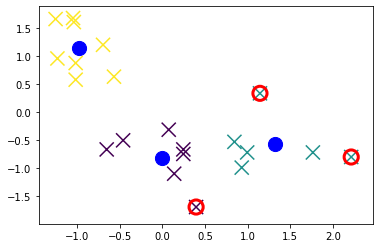

In [40]:
fig = plt.figure()
# plotting initial data
plt.scatter(*zip(*scaled_features_2),c=clusters,marker = "x", s=200) 
# plotting red ovals around outlier points
plt.scatter(*zip(*outliers),marker="o",facecolor="None",edgecolor="r",linewidth=3,s=200);
# plotting centers as blue dots
plt.scatter(*zip(*centroids),marker="o",facecolor="b",edgecolor="b",s=200);

Se ha detectado que los puntos referidos a los años 2000, 2003 y 2006 tienen una distancia muy alta y podrían no estar incluidos dentro de los clusters. 

In [57]:
anios_outliers = [2000, 2003, 2006]
boolean = [False if anio in anios_outliers else True for anio in data['Año'].tolist()]
cols = ['5xDestino','5xNCM']
scaled_no_outliers = scaler.fit_transform(data[boolean][cols])

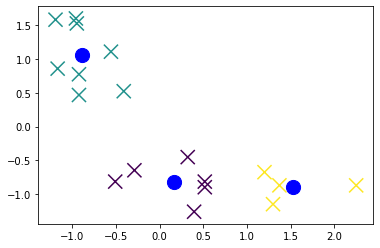

In [59]:
clusters = kmeans2.fit_predict(scaled_no_outliers)
# obtaining the centers of the clusters
centroids = kmeans2.cluster_centers_
# points array will be used to reach the index easy
points = np.empty((0,len(scaled_no_outliers[0])), float)
# distances will be used to calculate outliers
distances = np.empty((0,len(scaled_no_outliers[0])), float)
# getting points and distances
for i, center_elem in enumerate(centroids):
    # cdist is used to calculate the distance between center and other points
    distances = np.append(distances, cdist([center_elem],scaled_no_outliers[clusters == i], 'euclidean')) 
    points = np.append(points, scaled_no_outliers[clusters == i], axis=0)

fig = plt.figure()
# plotting initial data
plt.scatter(*zip(*scaled_no_outliers),c=clusters,marker = "x", s=200) 
# plotting centers as blue dots
plt.scatter(*zip(*centroids),marker="o",facecolor="b",edgecolor="b",s=200);

## Plot con clusters y outliers

In [68]:
data.loc[data['Año'].isin(anios_outliers),'cluster_label_2']=3

In [54]:
from babel.numbers import format_currency
from matplotlib.lines import Line2D
import matplotlib.ticker as mtick
import seaborn as sns

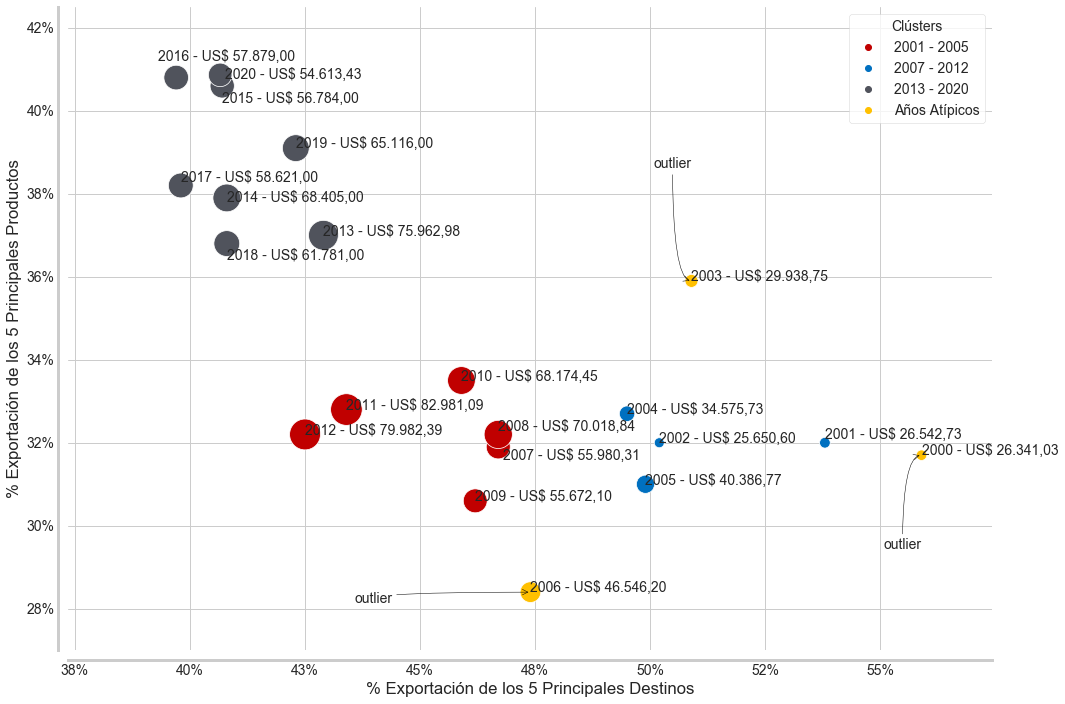

In [91]:
#Figsize
plt.rcParams["figure.figsize"] = (15,10)
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['savefig.facecolor']='white'

#Colors
colores = ['#C00000','#0070C0','#50535C',"#FFC000"]

#Bubbles
sns.set_style("whitegrid")
bubble = sns.scatterplot(data=data, x="5xDestino", 
                         y="5xNCM", size="expo", 
                         legend=False, sizes=(100,1000), 
                         hue='cluster_label_2', 
                         palette= colores)
bubble.set(xlabel='% Exportación de los 5 Principales Destinos', ylabel='% Exportación de los 5 Principales Productos')

#Text
text = data['Año'].astype('str')+(" - ")+data['expo'].apply(lambda x: format_currency(x, 'USD', locale='es_CO'))
        #2000 ,   2001  , 2002, 2003, 2004, 2005, 2006,     2007     ,    2008 , 2009, 2010, 2011, 2012, 2013,   2014   ,   2015   ,      2016    ,   2017  ,    2018  , 2019, 2020
moves = [(0,0),(0,0.001),(0,0),(0,0),(0,0),(0,0),(0,0),(0.001,-0.003),(0,0.001),(0,0),(0,0),(0,0),(0,0),(0,0),(0,-0.001),(0,-0.004),(-0.004,0.004),(0,0.001),(0,-0.004),(0,0),(0.001,-0.001)]
for x,y,t,(mx,my) in zip(data['5xDestino'], data['5xNCM'],text, moves): 
  plt.annotate(t,xy=(x,y),xytext=(x+mx,y+my))

moves2 = [(0,-0.02),(0,0.03),(-0.03,0)]
for x,y,(mx,my) in zip(data.loc[data['Año'].isin(anios_outliers),'5xDestino'],
               data.loc[data['Año'].isin(anios_outliers),'5xNCM'],moves2):
    plt.annotate('outlier', xy=(x,y),
            xytext=(x+mx, y+my),
            arrowprops=dict(connectionstyle="angle3", arrowstyle="->", color='black'),
            horizontalalignment='right', verticalalignment='top')


#Axis
plt.ylim([0.27, 0.425])
bubble.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0,decimals=0))
bubble.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0,decimals=0))
sns.despine(offset=10, trim=False)

#Legend
legend_labels = ["2001 - 2005","2007 - 2012","2013 - 2020","Años Atípicos"]
custom = [Line2D([], [], marker='o', color=colores[i], linestyle='None') for i in range(len(colores))]
plt.legend(custom, legend_labels, loc='upper right', title="Clústers")

plt.tight_layout()

#plt.show()
plt.savefig('clusters&outliers.png', dpi=200)
#from google.colab import files
#files.download('clusters&outliers.png')